## Define the Convolutional Neural Network



In this notebook and in `models.py`, we will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***




In [61]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2018-11-07 14:11:45--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.81.187
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.81.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.5’

train-test-data.zip 100%[===================>] 322.93M  62.6MB/s    in 5.4s    

2018-11-07 14:11:51 (60.2 MB/s) - ‘/data/train-test-data.zip.5’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [62]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:


import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=136, bias=True)
  (drop): Dropout(p=0.5)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.



In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor




train_data_transform = transforms.Compose([Rescale((250, 250)), \
                                           RandomCrop((224, 224)), \
                                           Normalize(), \
                                           ToTensor()])

test_data_transform = transforms.Compose([Rescale((224, 224)), \
                                          Normalize(), \
                                          ToTensor()])

assert(train_data_transform is not None), 'Define a data_transform'

ModuleNotFoundError: No module named 'torch'

In [65]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=train_data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. 



In [66]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


In [67]:


# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=test_data_transform)



In [68]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, we have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [69]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net.forward(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [70]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.



In [71]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [72]:
test_images[0].data

tensor([[[ 0.1451,  0.1451,  0.1412,  ...,  0.2667,  0.2706,  0.2706],
         [ 0.1451,  0.1412,  0.1412,  ...,  0.2667,  0.2706,  0.2706],
         [ 0.1451,  0.1412,  0.1412,  ...,  0.2667,  0.2667,  0.2706],
         ...,
         [ 0.5882,  0.5373,  0.5451,  ...,  0.6667,  0.5882,  0.5490],
         [ 0.5804,  0.5176,  0.5216,  ...,  0.6431,  0.5725,  0.5490],
         [ 0.5333,  0.4549,  0.4706,  ...,  0.6275,  0.5686,  0.5529]]])

#### Un-transformation

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; 

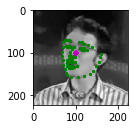

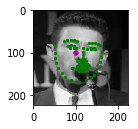

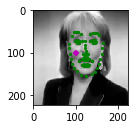

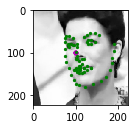

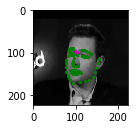

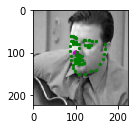

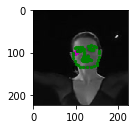

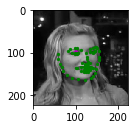

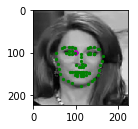

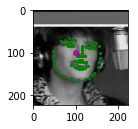

In [73]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

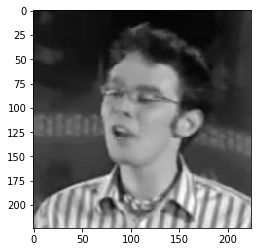

In [74]:
image = test_images[0].data   # get the image from it's Variable wrapper

plt.imshow(np.squeeze(image), cmap='gray')


## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. 




In [75]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)


In [76]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [77]:
# train your network
n_epochs = 1 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.18346793130040168
Epoch: 1, Batch: 20, Avg. Loss: 0.07867010831832885
Epoch: 1, Batch: 30, Avg. Loss: 0.0629084050655365
Epoch: 1, Batch: 40, Avg. Loss: 0.059584741666913035
Epoch: 1, Batch: 50, Avg. Loss: 0.06060613393783569
Epoch: 1, Batch: 60, Avg. Loss: 0.05586979500949383
Epoch: 1, Batch: 70, Avg. Loss: 0.0660232812166214
Epoch: 1, Batch: 80, Avg. Loss: 0.058817286789417264
Epoch: 1, Batch: 90, Avg. Loss: 0.05774617306888104
Epoch: 1, Batch: 100, Avg. Loss: 0.04665022306144238
Epoch: 1, Batch: 110, Avg. Loss: 0.05657535083591938
Epoch: 1, Batch: 120, Avg. Loss: 0.05112784542143345
Epoch: 1, Batch: 130, Avg. Loss: 0.05580541230738163
Epoch: 1, Batch: 140, Avg. Loss: 0.053727827966213226
Epoch: 1, Batch: 150, Avg. Loss: 0.048199164867401126
Epoch: 1, Batch: 160, Avg. Loss: 0.05666316226124764
Epoch: 1, Batch: 170, Avg. Loss: 0.05657098852097988
Epoch: 1, Batch: 180, Avg. Loss: 0.05491690933704376
Epoch: 1, Batch: 190, Avg. Loss: 0.05530858691781759


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [78]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


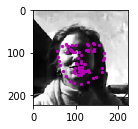

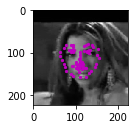

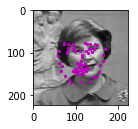

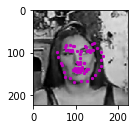

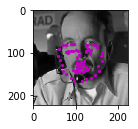

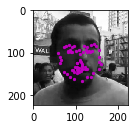

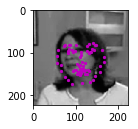

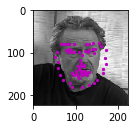

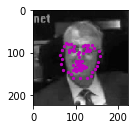

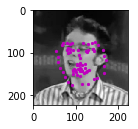

In [79]:

# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts=None)


In [80]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

[[ -4.35675867e-03   3.14993896e-02   1.17016546e-02   1.33001171e-02
   -7.74955750e-03  -1.58136729e-02  -1.92131475e-02]
 [ -1.22787002e-02   1.35914721e-02   1.96265206e-02  -1.83202326e-04
    4.05676290e-03   2.93814503e-02   9.61660966e-03]
 [ -1.16890632e-02   1.64133422e-02   1.12814046e-02  -1.45968217e-02
   -2.90291756e-03  -3.18457521e-02   1.51948631e-02]
 [  2.63982564e-02  -1.36501845e-02   7.78090209e-03  -9.81092453e-05
    1.67319030e-02   9.39336047e-03   2.68334448e-02]
 [  3.40914391e-02  -7.09976070e-03   2.64963545e-02  -2.76430398e-02
   -2.56005730e-02   1.45265311e-02  -3.07673998e-02]
 [ -2.21027732e-02  -2.89232209e-02   7.34130293e-03  -2.87062638e-02
    3.50678004e-02   3.13966349e-03   1.56068429e-03]
 [  2.41352320e-02  -3.52925658e-02  -3.26736793e-02   2.67315172e-02
   -1.03314854e-02   5.77988103e-03  -2.01231241e-02]]
(7, 7)


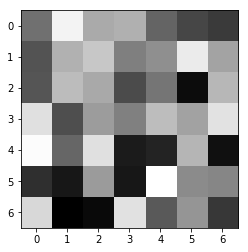

In [8]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


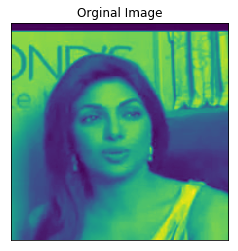

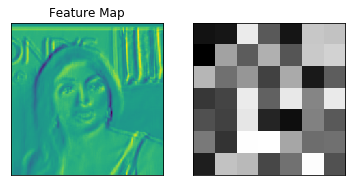

In [34]:

import cv2

weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

idx_img = 0
img = np.squeeze(test_images[idx_img].data.numpy())
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.title("Orginal Image")

filtered_img = cv2.filter2D(img, -1, w[filter_index][0])

fig = plt.figure()
ax = fig.add_subplot(121, xticks = [], yticks = [])
ax.imshow(filtered_img)
ax.set_title("Feature Map")
ax = fig.add_subplot(122, xticks = [], yticks = [])
ax.imshow(w[filter_index][0], cmap = 'gray')

plt.show()